In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import linregress

from toolbar.masked import masked
from toolbar.significance_test import r_test

import tqdm as tq


def S_T_data(S, T):
    Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc") # 读取数据
    EHD = Tmax_5Day_filt - T
    EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
    EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
    EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
    CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
    zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
    EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
    EHDstations_zone = EHDstations_zone.data.reshape(-1)
    EHDstations_zone = np.where(EHDstations_zone >= S, EHDstations_zone, 0)  # 提取极端高温日占比大于S
    return EHDstations_zone

# 数据读取
Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
T_th = 0.90
t95 = masked(Tmax_5Day_filt, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").mean(dim=['year', 'day']).quantile(T_th)  # 夏季内 长江中下游流域 分位数
EHD = Tmax_5Day_filt - t95
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD = masked(EHD, r"D:\PyFile\map\self\长江_TP\长江_tp.shp")  # 掩膜处理得长江流域EHD温度距平
CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\self\长江_TP\长江_tp.shp").sum()['tmax'].data
EHDstations_zone = EHD.sum(dim=['lat', 'lon']) / zone_stations  # 长江流域逐日极端高温格点占比
EHDstations_zone = EHDstations_zone.data.reshape(-1)
standard = np.where(EHDstations_zone >= 0.3, EHDstations_zone, 0)  # 提取极端高温日占比大于S

corr = []
for iT in tq.tqdm(np.arange(30, 38.01, 0.1)):
    corr_ = []
    for iS in np.arange(0.1, 0.901, 0.01):
        other_standard = S_T_data(iS, iT)
        r = np.corrcoef(standard, other_standard)[0, 1]
        corr_.append(r)
    corr.append(corr_)

C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
  0%|          | 0/81 [00:00<?, ?it/s]C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\xarray\coding\times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
C:\Users\86136\.conda\envs\Meteorologi

In [11]:
import toolbar.significance_test as st

st.r_test(5456, 0.01)

0.034869629852526944

In [2]:
corr = np.array(corr)
np.save(r"D:\PyFile\p2\data\corr.npy", corr)

C:\Users\86136\AppData\Local\Temp\ipykernel_19064\3137785640.py:16: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in edge_contf.collections:


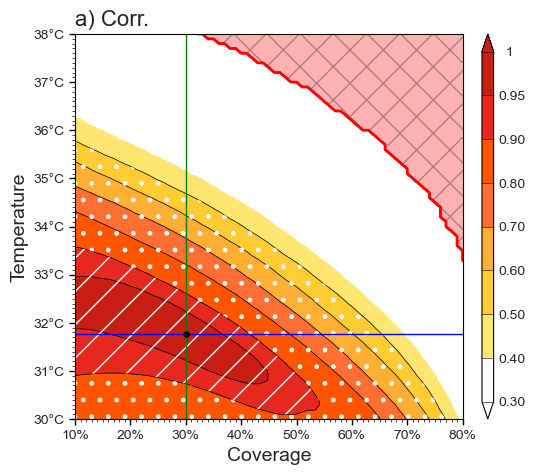

In [235]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
import seaborn as sns
import cmaps

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_title("a) Corr.", fontsize=16, loc='left')
contf = ax.contourf(np.arange(0.1, 0.801, 0.01), np.arange(30, 38.01, 0.1), corr[:, :-10], cmap=cmaps.sunshine_9lev, levels=[.3, .4, .5, .6, .7, .8, .9, .95, 1], extend='both')
cont = ax.contour(np.arange(0.1, 0.801, 0.01), np.arange(30, 38.01, 0.1), corr[:, :-10], levels=[.5, .6, .7, .8, .9, .95, 1.], colors='k', linewidths=.5)
xianzhu_contf = ax.contourf(np.arange(0.1, 0.801, 0.01), np.arange(30, 38.01, 0.1), corr[:, :-10], [0, .5, .9, 1], hatches=[None, '.', '/'], colors="none", zorder=2)
corr_edge = np.where(np.isnan(corr), 0, corr)
edge_cont = ax.contour(np.arange(0.1, 0.901, 0.01), np.arange(30, 38.01, 0.1), corr_edge[:, :], levels=[0], colors='red', linewidths=2)
edge_contf = ax.contourf(np.arange(0.1, 0.901, 0.01), np.arange(30, 38.01, 0.1), corr_edge[:, :], [-99, 0], hatches=['x'], colors="red", alpha=0.3)
for collection in edge_contf.collections:
    collection.set_edgecolor('k')#-----打点颜色设置
# 设置x=0.3的线
ax.axvline(0.3, color='g', linestyle='-', linewidth=1)
# 设置y=31.76的线
ax.axhline(31.76, color='b', linestyle='-', linewidth=1)
# 设置(0.3, 31.76)的点
ax.scatter(0.3, 31.76, color='k', s=15, zorder=2)
# 设置x轴
ax.set_xlabel("Coverage", fontsize=14)
ax.set_xlim(0.1, 0.8)
ax.set_xticks(np.arange(0.1, 0.801, 0.1))
ax.set_xticklabels([f"{i*100:.0f}%" for i in np.arange(0.1, 0.801, 0.1)], fontsize=10)
# 设置x轴主次刻度
ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(0.1, 0.801, 0.1)))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
# 设置y轴主次刻度
ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(30, 38.01, 1)))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# 设置y轴
ax.set_ylabel("Temperature", fontsize=14, rotation=90)
ax.set_ylim(30, 38)
ax.set_yticks(np.arange(30, 38.01, 1))
ax.set_yticklabels([f"{i:.0f}°C" for i in np.arange(30, 38.01, 1)], fontsize=10)
ax.grid(False)  # 不显示网格
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax.tick_params(which='major', length=4, width=1, color='black')  # 最大刻度长度，宽度设置，
ax.tick_params(which='minor', length=2, width=.5, color='black')  # 最小刻度长度，宽度设置
ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
plt.rcParams['ytick.direction'] = 'out'  # 将x轴的刻度线方向设置向内或者外
# 边框显示为黑色
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
# 显示颜色条
ax_colorbar = inset_axes(ax, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cb1 = plt.colorbar(contf, cax=ax_colorbar, orientation='vertical', drawedges=True)
cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
cb1.ax.tick_params(length=0, labelsize=10)  # length为刻度线的长度
cb1.locator = ticker.FixedLocator(np.array([.3, .4, .5, .6, .7, .8, .9, .95, 1.]))
cb1.set_ticklabels(["0.30", "0.40", "0.50", "0.60", "0.70", "0.80", "0.90", "0.95", "  1 "])
plt.savefig(r"D:\PyFile\p2\pic\corr.png", dpi=600, bbox_inches='tight')
plt.show()